In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

from matplotlib.patches import Rectangle
from tensorflow.keras.preprocessing import image
from glob import glob
from skimage.transform import resize
from skimage.util import img_as_ubyte

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png

File ‘charmander-tight.png’ already there; not retrieving.

File ‘bulbasaur-tight.png’ already there; not retrieving.

File ‘squirtle-tight.png’ already there; not retrieving.



In [ ]:
!ls

backgrounds	 bulbasaur-tight.png   __MACOSX     squirtle-tight.png
backgrounds.zip  charmander-tight.png  sample_data


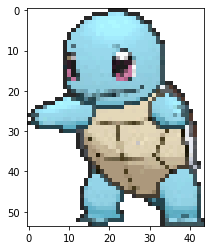

In [ ]:
ch = imageio.imread('charmander-tight.png')
bb = imageio.imread('bulbasaur-tight.png')
sq = imageio.imread('squirtle-tight.png')
plt.imshow(sq)
plt.show()

In [ ]:
IMG_SIZE = 200

ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)

CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

pokemon_data = [
  [ch, CH_H, CH_W, CH_C],
  [bb, BB_H, BB_W, BB_C],
  [sq, SQ_H, SQ_W, SQ_C]
]

class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

File ‘backgrounds.zip’ already there; not retrieving.



In [ ]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip


In [ ]:
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for background_file in background_files:
  bg = np.array(image.load_img(background_file))
  backgrounds.append(bg)

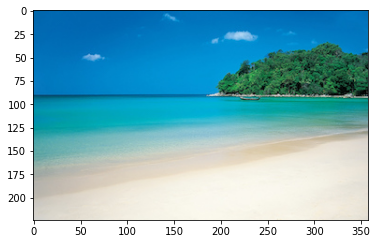

In [ ]:
plt.imshow(backgrounds[2])
plt.show()

In [ ]:
def multiclass_image_generator_bg(batch_size=5):
  while True:
      X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3))
      Y = np.zeros((batch_size, 8))

      for i in range(batch_size):
        # randomly select a background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_x = np.random.randint(bg_h - IMG_SIZE)
        rnd_y = np.random.randint(bg_w - IMG_SIZE)
        X[i] = bg[rnd_x:rnd_x+IMG_SIZE, rnd_y:rnd_y+IMG_SIZE].copy()

        # object probably appears
        appear = (np.random.random() < 0.75)
        if appear:
          
          # choose a pokemon
          global pokemon_data
          pk_idx = np.random.randint(3)
          pk, h, w, _ = pokemon_data[pk_idx]

          # resize pokemon
          scale = 0.5 + np.random.random()
          h_new = int(h * scale)
          w_new = int(w * scale)
          pk_new = img_as_ubyte(resize(pk, (h_new, w_new)))

          # flip Charmander with probability
          if np.random.random() < 0.5:
            pk_new = np.fliplr(pk_new)

          # locate a region for pokemon randomly
          row0 = np.random.randint(IMG_SIZE - h_new)
          col0 = np.random.randint(IMG_SIZE - w_new)
          row1 = row0 + h_new
          col1 = col0 + w_new

          # process Charmander and background so that we get the desired 
          # result when adding them together
          mask = (pk_new[:, :, 3] == 0) # find where the pokemon is 0
          bg_slice = X[i, row0:row1, col0:col1, :] # where we want to place pokemon
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) * (h, w, 3)
          bg_slice += pk_new[:, :, :3] # "add" pokemon to the slice
          X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

          # make targets by normalization 
          Y[i, 0] = row0 / IMG_SIZE
          Y[i, 1] = col0 / IMG_SIZE
          Y[i, 2] = (row1 - row0) / IMG_SIZE
          Y[i, 3] = (col1 - col0) / IMG_SIZE

          # class
          Y[i, 4 + pk_idx] = 1

        Y[i, 7] = appear

      yield X / 255.0, Y

[0. 0. 0. 0. 0. 0. 0. 0.]


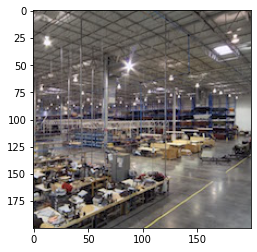

In [ ]:
X, Y = next(multiclass_image_generator_bg())
print(Y[0])
plt.imshow(X[0])
plt.show()

In [ ]:
def custom_loss(y_true, y_pred):
  bce1 = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # bounding box
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # object class
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

  return y_true[:, -1] * bce1 + y_true[:, -1] * cce + 0.5 * bce2 

In [ ]:
def make_model():
  vgg = tf.keras.applications.VGG16(
      input_shape=[IMG_SIZE, IMG_SIZE, 3], 
      include_top=False, 
      weights='imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x)
  x2 = Dense(3, activation='softmax')(x)
  x3 = Dense(1, activation='sigmoid')(x)
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))

  return model

In [ ]:
model = make_model()
model.fit(
    multiclass_image_generator_bg(),
    steps_per_epoch=100,
    epochs=8
)

Epoch 1/8
100/100 [==============================] - 10s 96ms/step - loss: 1.4903
Epoch 2/8
100/100 [==============================] - 10s 98ms/step - loss: 0.8390
Epoch 3/8
100/100 [==============================] - 10s 96ms/step - loss: 0.5895
Epoch 4/8
100/100 [==============================] - 9s 94ms/step - loss: 0.4496
Epoch 5/8
100/100 [==============================] - 9s 93ms/step - loss: 0.4921
Epoch 6/8
100/100 [==============================] - 9s 92ms/step - loss: 0.4059
Epoch 7/8
100/100 [==============================] - 9s 92ms/step - loss: 0.4153
Epoch 8/8
100/100 [==============================] - 9s 93ms/step - loss: 0.4097


In [ ]:
def pokemon_multiclass_prediction_bg():
  # randomly select a background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_x = np.random.randint(bg_h - IMG_SIZE)
  rnd_y = np.random.randint(bg_w - IMG_SIZE)
  x = bg[rnd_x:rnd_x+IMG_SIZE, rnd_y:rnd_y+IMG_SIZE].copy()

  # object probably appears
  appear = (np.random.random() < 0.75)
  if appear:
    # choose a pokemon
    global pokemon_data
    pk_idx = np.random.randint(3)
    pk, h, w, _ = pokemon_data[pk_idx]

    # resize Charmander
    scale = 0.5 + np.random.random()
    h_new = int(h * scale)
    w_new = int(w * scale)
    pk_new = img_as_ubyte(resize(pk, (h_new, w_new)))

    # flip Charmander with probability
    if np.random.random() < 0.5:
      pk_new = np.fliplr(pk_new)

    # locate a region for Charmander randomly
    row0 = np.random.randint(IMG_SIZE - h_new)
    col0 = np.random.randint(IMG_SIZE - w_new)
    row1 = row0 + h_new
    col1 = col0 + w_new

    # process Charmander and background so that we get the desired 
    # result when adding them together
    mask = (pk_new[:, :, 3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1, col0:col1, :] # where we want to place pokemon
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) * (h, w, 3)
    bg_slice += pk_new[:, :, :3] # "add" pokemon to the slice
    x[row0:row1, col0:col1, :] = bg_slice # put the slice back

    print("True:", [row0, col0, row1, col1])

  # predict
  X = np.expand_dims(x, 0) / 255.0
  p = model.predict(X)[0]
  
  # plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))

  # draw predicted bounding box if there is any
  if p[7] > 0.5:
    rect = Rectangle(
        (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
        p[3]*IMG_SIZE, 
        p[2]*IMG_SIZE, 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none')
    ax.add_patch(rect)
    print("Pred:", (p[0:4] * IMG_SIZE).astype(int).tolist())
  else:
    print("No object exists")

  plt.show()

No object exists


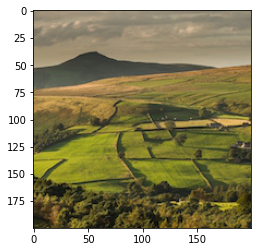

In [ ]:
pokemon_multiclass_prediction_bg()